In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.mlab
import scipy.io.wavfile
import scipy
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset.slice_file_name = 'audio/fold' + dataset.fold.astype(str) + '/' + dataset.slice_file_name
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
1129,audio/fold8/125678-7-4-4.wav,125678,96.843843,100.843843,1,8,7,jackhammer
3860,audio/fold1/177621-0-0-105.wav,177621,52.500000,56.500000,2,1,0,air_conditioner
177,audio/fold1/103074-7-1-3.wav,103074,24.017317,28.017317,1,1,7,jackhammer
696,audio/fold8/113202-5-0-15.wav,113202,7.500000,11.500000,1,8,5,engine_idling
3568,audio/fold4/173994-3-0-44.wav,173994,22.000000,26.000000,1,4,3,dog_bark


In [3]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [4]:
learning_rate = 0.001
time_stamp = 64
dimension = 512
batch_size = 128
epoch = 20
num_layers = 3
size_layer = 256

In [5]:
def processAudio(audio_file):
    rate, data = scipy.io.wavfile.read(audio_file)
    try:
        if data.shape[1]:
            data = np.mean(data, axis = 1)
    except:
        pass
    audio = matplotlib.mlab.specgram(data)[0]
    return scipy.misc.imresize(audio, [time_stamp, dimension])

In [6]:
class Model:
    
    def __init__(self, size_output):
        
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer)
        
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)])
        
        self.X = tf.placeholder(tf.float32, [None, None, dimension])
        self.Y = tf.placeholder(tf.float32, [None, size_output])
        
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, dtype = tf.float32)
        
        rnn_W = tf.Variable(tf.random_normal((size_layer, size_output)))
        rnn_B = tf.Variable(tf.random_normal([size_output]))
        self.logits = tf.matmul(self.outputs[:, -1], rnn_W) + rnn_B
        
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

In [7]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(no_classes)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [8]:
ACCURACY, LOST = [], []
for i in range(epoch):
    last = time.time()
    total_acc, total_loss = 0, 0
    for k in range(0, (train_dataset.shape[0] // batch_size) * batch_size, batch_size):
        batch_x, batch_y = [], []
        for n in range(batch_size):
            try:
                batch_x.append(processAudio(train_dataset.slice_file_name.iloc[k + n]))
                onehot = np.zeros((no_classes))
                onehot[train_dataset.classID.iloc[k + n]] = 1.0
                batch_y.append(onehot)
            except Exception as e:
                continue
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= (train_dataset.shape[0] // batch_size)
    total_acc /= (train_dataset.shape[0] // batch_size)
    ACCURACY.append(total_acc)
    LOST.append(total_loss)
    print('epoch: ', i + 1, 'avg loss: ', total_loss, 'avg acc: ', total_acc, 'avg time: ', (time.time() - last) / (train_dataset.shape[0] // batch_size))

('epoch: ', 1, 'avg loss: ', 2.1510376665327282, 'avg acc: ', 0.26169908640009387, 'avg time: ', 1.3004957967334323)
('epoch: ', 2, 'avg loss: ', 1.8687300240551983, 'avg acc: ', 0.32877649891155736, 'avg time: ', 1.295422112500226)
('epoch: ', 3, 'avg loss: ', 1.7374366014092057, 'avg acc: ', 0.38838847423041306, 'avg time: ', 1.2957094245486789)
('epoch: ', 4, 'avg loss: ', 1.5682201716634963, 'avg acc: ', 0.45382225623837225, 'avg time: ', 1.2962347578119349)
('epoch: ', 5, 'avg loss: ', 1.4230377409193251, 'avg acc: ', 0.5331389175521003, 'avg time: ', 1.2961179282930162)
('epoch: ', 6, 'avg loss: ', 1.2770085555535775, 'avg acc: ', 0.57837841080294716, 'avg time: ', 1.295755315709997)
('epoch: ', 7, 'avg loss: ', 1.2246687677171495, 'avg acc: ', 0.61030772217997797, 'avg time: ', 1.2962308724721272)
('epoch: ', 8, 'avg loss: ', 1.0784213024157066, 'avg acc: ', 0.65618068531707485, 'avg time: ', 1.2960012753804524)
('epoch: ', 9, 'avg loss: ', 1.0243017044332292, 'avg acc: ', 0.677

In [9]:
batch_x, batch_y, labels = [], [], []
for n in range(128):
    try:
        batch_x.append(processAudio(test_dataset.slice_file_name.iloc[n]))
        onehot = np.zeros((no_classes))
        onehot[test_dataset.classID.iloc[n]] = 1.0
        batch_y.append(onehot)
        labels.append(test_dataset.classID.iloc[n])
    except Exception as e:
        continue
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
print 'testing accuracy: ' + str(acc)
print(metrics.classification_report(labels, logits, target_names = np.unique(unique_sound)))

testing accuracy: 0.453488
                  precision    recall  f1-score   support

 air_conditioner       0.35      0.55      0.43        11
        car_horn       0.50      0.40      0.44         5
children_playing       0.20      0.11      0.14         9
        dog_bark       1.00      0.64      0.78        11
        drilling       0.38      0.45      0.42        11
   engine_idling       1.00      0.44      0.62         9
        gun_shot       1.00      0.50      0.67         2
      jackhammer       0.50      0.60      0.55        10
           siren       0.50      0.22      0.31         9
    street_music       0.26      0.56      0.36         9

     avg / total       0.54      0.45      0.46        86



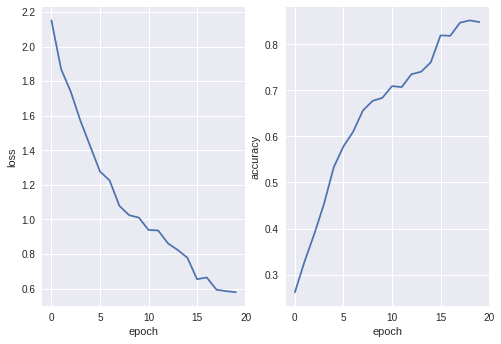

In [10]:
EPOCH = np.arange(len(LOST))
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()